In [1]:
# Standard library imports
import os
import sys
import warnings

# Third party imports
import numpy as np
import matplotlib.pyplot as plt
import mat73
import rpy2.robjects as robjects
from scipy.signal import butter, find_peaks, lfilter

# Local imports
from src.features.preprocessing import *
from src.visualization.data_vis import *

# Notebook magic
%matplotlib inline

First we can load data and print a summary of what kinds of neurons are available from the complete dataset.

In [2]:
# Load up a file of interest
recording_of_interest = "fitted_data_mjc58-2301-0117.mat"
file_data = mat73.loadmat('/'.join([os.getcwd(), 'data', 'raw', recording_of_interest]))

# Picking out some of the data structures of interest
qspike = file_data['qspike'] # aligned spike times 
pyrspike = file_data['pyrspike']
intspike = file_data['intspike']
time_pos = file_data['time_pos'] # [1, nt] time vector with the time; dt = t[1] - t[0]
BP = file_data['BP']
theta = file_data['lfp']
theta_time_axis = file_data['time_eeg']
trial_theta_start_indices = (file_data['tp']*file_data['fs2']).astype(int)

# Define some constants for the data
dt = time_pos[1] - time_pos[0]
T = dt*time_pos.size

# Summarize neuron population
print(f'Number of pyramidal neurons: {len(list(set(pyrspike[:, 0])))}')
print(f'pyramidal start label: {np.amin(pyrspike[:, 0])}')
print(f'pyramidal end label: {np.amax(pyrspike[:, 0])}\n')

print(f'Number of interneurons: {len(list(set(intspike[:, 0])))}')
print(f'interneuron start label: {np.amin(intspike[:, 0])}')
print(f'interneuron end label: {np.amax(intspike[:, 0])}')

Number of pyramidal neurons: 107
pyramidal start label: 1.0
pyramidal end label: 107.0

Number of interneurons: 14
interneuron start label: 108.0
interneuron end label: 121.0


Next, let's remove interneurons from the spike-aligned data, print off any missing pyramidals, ensure the data is structured how some of the preprocessing algorithms assume and create a list which will allow me to combine trial data.

In [3]:
# Prepare data, note missing data and ensure it is structured appropriately

# Eliminate interneurons
interneuron_indices = []
for i, label in enumerate(qspike[:, 2]):
    if label in intspike[:, 0]:
        interneuron_indices.append(i)
pyr_qspike = np.delete(qspike, interneuron_indices, axis=0)

# Note any pyramidals missing from qspike
pyr_missing = []
pyr_qspike_labels = np.array(list(set(pyr_qspike[:, 2])))
pyr_labels = np.array(list(set(pyrspike[:, 0])))
for label in pyr_labels:
    if label not in pyr_qspike_labels:
        pyr_missing.append(label)
print(f'Pyramidal neurons {pyr_missing} absent from spike-aligned data.')

# Ensure trial data is partitioned nicely for each neuron
if not np.all(np.diff(pyr_qspike[:, 2]) >= 0):
    raise Exception('Neuron data is not consolidated in pyr_qspike')
successes = 0
pyr_num_trials = []
for label in pyr_qspike_labels:
    single_neuron_data = pyr_qspike[np.where(pyr_qspike[:, 2] == label)]
    trials = list(single_neuron_data[:, 0]) # Intermediate variable
    if not np.all(np.diff(trials) >= 0) and not np.all(np.diff(trials) < 2):
        raise Exception(f'Neuron {label}\'s trial data is either not sorted or skips trials')
    trials = list(set(single_neuron_data[:, 0]))
    if len(trials) != 0:
        pyr_num_trials.append(len(trials))

# Create a list for indexing trial data corresponding to individual pyramidal cells
pyr_trial_start_indices = []
for i in range(len(pyr_num_trials)):
    pyr_trial_start_indices.append(sum(pyr_num_trials[:i]))

# Create a label vector for the individual trials
pyr_trial_neuron_label = []
pyr_trial_number_label = []
for label_i, num_trials in enumerate(pyr_num_trials):
    pyr_trial_neuron_label.extend([pyr_qspike_labels[label_i] for trial in range(num_trials)])
    pyr_trial_number_label.extend(list(range(1, num_trials + 1)))

Pyramidal neurons [38.0, 66.0, 82.0, 86.0, 90.0] absent from spike-aligned data.


With that out of the way, let's create constructs that permits analysis of both the individual AND combined trial data for each neuron.  

In [4]:
# Separate out spike times for each trial
trial_partition_indices = partition_spikes(pyr_qspike)
trial_spike_times = separate_neuron_data(trial_partition_indices, pyr_qspike)

# Just as in the initial data exploration, we can combine spike times across trials
pyr_combined_trials = []
for i, start_i in enumerate(pyr_trial_start_indices):
    if i == 0:
        neuron_data = trial_spike_times[0:pyr_trial_start_indices[1]]
        pyr_combined_trials.append(np.concatenate(neuron_data, axis=0))
    elif i < len(pyr_trial_start_indices) - 1:
        neuron_data = trial_spike_times[start_i:pyr_trial_start_indices[i + 1]]
        pyr_combined_trials.append(np.concatenate(neuron_data, axis=0))
    else:
        neuron_data = trial_spike_times[start_i:]
        pyr_combined_trials.append(np.concatenate(neuron_data, axis=0))

In [5]:
# Control parameters
N = 512
bandwidth = 0.02
verbose = False

# Dominant Frequency Analysis: individual trials
kde_x_indiv, kde_y_indiv = r_spike_kde(trial_spike_times, bandwidth, N)
print(len(kde_x_indiv))

dominant_frequencies_indiv = np.empty((len(kde_x_indiv), 2))
for i, kde_x in enumerate(kde_x_indiv):
    if verbose == True:
        dom_freq_fft, dom_freq_time = dominant_frequency(kde_x, kde_y_indiv[i], plot=True)
        print(f'Dom freq FFT: {dom_freq_fft}; Dom freq time: {dom_freq_time}')
        print(f'Dom freq error: {np.abs(dom_freq_fft - dom_freq_time)}')
    else:
        dom_freq_fft, dom_freq_time = dominant_frequency(kde_x, kde_y_indiv[i], plot=False)
    
    # Store the dominant frequency returned by each method
    dominant_frequencies_indiv[i, 0] = dom_freq_fft
    dominant_frequencies_indiv[i, 1] = dom_freq_time

# Clean up by ditching undefined frequencies
nan_rows = []
for row_i, val in enumerate(dominant_frequencies_indiv[:, 0]):
    if np.isnan(val) == True:
        nan_rows.append(row_i)
dominant_frequencies_indiv = np.delete(dominant_frequencies_indiv, nan_rows, axis=0) # Delete undefined frequencies

# Delete corresponding entries in label vectors to preserve accuracy
pyr_trial_number_label = np.delete(np.array(pyr_trial_number_label), nan_rows) 
pyr_trial_neuron_label = np.delete(np.array(pyr_trial_neuron_label), nan_rows)
for i in sorted(nan_rows, reverse=True):
    del kde_x_indiv[i]
    del trial_spike_times[i]

1719


In [6]:
# Control parameters
N = 512
bandwidth = 0.02
verbose = False

# Dominant Frequency Analysis: combined trials
kde_x_combined, kde_y_combined = r_spike_kde(pyr_combined_trials, bandwidth, N)

dominant_frequencies_combined = np.empty((len(kde_x_combined), 2))
for i, kde_x in enumerate(kde_x_combined):
    if verbose == True:
        dom_freq_fft, dom_freq_time = dominant_frequency(kde_x, kde_y_combined[i], plot=True)
        print(f'Dom freq FFT: {dom_freq_fft}; Dom freq time: {dom_freq_time}')
        print(f'Dom freq error: {np.abs(dom_freq_fft - dom_freq_time)}')
    else:
        dom_freq_fft, dom_freq_time = dominant_frequency(kde_x, kde_y_combined[i], plot=False)
    
    # Store the dominant frequency returned by each method
    dominant_frequencies_combined[i, 0] = dom_freq_fft
    dominant_frequencies_combined[i, 1] = dom_freq_time

# Clean up by ditching undefined frequencies
nan_rows = []
for row_i, val in enumerate(dominant_frequencies_combined[:, 0]):
    if np.isnan(val) == True:
        nan_rows.append(row_i)
dominant_frequencies_combined = np.delete(dominant_frequencies_combined, nan_rows, axis=0) # Delete undefined frequencies

Dominant frequency distribution: individual trials


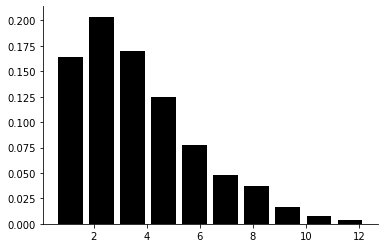

Dominant frequency distribution: neuron-combined trials


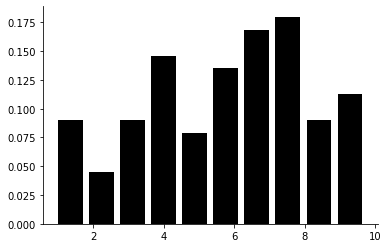

In [7]:
# Visualize Dominant Frequencies
print("Dominant frequency distribution: individual trials")
spike_frequency_histogram(dominant_frequencies_indiv[:, 1], num_bins=10)
print("Dominant frequency distribution: neuron-combined trials")
spike_frequency_histogram(dominant_frequencies_combined[:, 1], num_bins=10)

In [8]:
# Signal characteristics
theta_fs = theta_time_axis.size/theta_time_axis[-1] # Sampling frequency
theta_nyq = 0.5*theta_fs

# Filter characteristics
filter_order = 2
lowcut = 6 / theta_nyq 
highcut = 10 / theta_nyq

# Create and apply the filter
b, a = butter(filter_order, [lowcut, highcut], btype='band') # The IIR
theta_filtered = lfilter(b, a, theta) # Applying the filter

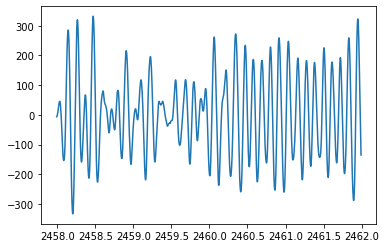

In [9]:
# Extract theta epochs corresponding to individual trials
trial_duration = 4 # seconds
trial_N = int(file_data['fs2']*trial_duration)

trial_theta_epochs = np.zeros((trial_theta_start_indices.size, trial_N))
trial_theta_epochs_x = np.zeros((trial_theta_start_indices.size, trial_N))
for i, start_i in enumerate(trial_theta_start_indices):
    trial_theta_epochs[i, :] = theta_filtered[start_i:start_i + trial_N]
    trial_theta_epochs_x[i, :] = theta_time_axis[start_i:start_i + trial_N]

# Visualize 
epoch_i = 6
plt.close()
fig, ax = plt.subplots()
ax.plot(trial_theta_epochs_x[epoch_i, :], trial_theta_epochs[epoch_i, :])

In [ ]:
# Classify individual trials as being either phase precession [1, 0] or not [0, 1]
verbose = True
bandwidth = 0.02
onehot_vector = np.zeros((dominant_frequencies_indiv.shape[0], 2), dtype=int)
for i, dom_freq in enumerate(dominant_frequencies_indiv[:, 1]):
    trial_i = pyr_trial_number_label[i] - 1
    trial_dur = kde_x_indiv[i][-1] - kde_x_indiv[i][0]
    trial_N = int(file_data['fs2']*trial_dur)
    theta_interval_y = theta_filtered[trial_theta_start_indices[trial_i]:trial_theta_start_indices[trial_i] + trial_N]
    theta_interval_x = theta_time_axis[trial_theta_start_indices[trial_i]:trial_theta_start_indices[trial_i] + trial_N]
    theta_freq = average_theta_freq(theta_interval_x, theta_interval_y)

    if verbose:
        kde_x, kde_y = r_spike_kde([trial_spike_times[i]], bandwidth, trial_N)
        PR_plot(kde_y[0], theta_interval_x, theta_interval_y)

    if dom_freq - theta_freq > 0:
        onehot_vector[i, 0] = 1
    else:
        onehot_vector[i, 1] = 1
print(pyr_trial_neuron_label[np.where(onehot_vector[:, 0] == 1)[0]])
